In [3]:
import pandas as pd
import numpy as np

In [4]:
f1 = './data/nasa_19950630.22-19950728.12.tsv_result_file.csv'

In [5]:
data = pd.read_csv(f1, low_memory=False)

In [7]:
data.head()

,host,sessionID,date (DD-MM-YYYY),time (HH:MM:SS),method,url,response
0,199.72.81.55,199.72.81.55_1,30-06-1995,10:30:01,GET,/history/apollo/,200
1,unicomp6.unicomp.net,unicomp6.unicomp.net_1,30-06-1995,10:30:06,GET,/shuttle/countdown/,200
2,199.120.110.21,199.120.110.21_1,30-06-1995,10:30:09,GET,/shuttle/missions/sts-73/mission-sts-73.html,200
3,burger.letters.com,burger.letters.com_1,30-06-1995,10:30:11,GET,/shuttle/countdown/liftoff.html,304
4,199.120.110.21,199.120.110.21_1,30-06-1995,10:30:11,GET,/shuttle/missions/sts-73/sts-73-patch-small.gif,200


In [8]:
html_requests = data[data['url'].str.contains("html")]

In [9]:
html_requests.head()

,host,sessionID,date (DD-MM-YYYY),time (HH:MM:SS),method,url,response
2,199.120.110.21,199.120.110.21_1,30-06-1995,10:30:09,GET,/shuttle/missions/sts-73/mission-sts-73.html,200
3,burger.letters.com,burger.letters.com_1,30-06-1995,10:30:11,GET,/shuttle/countdown/liftoff.html,304
7,205.212.115.106,205.212.115.106_1,30-06-1995,10:30:12,GET,/shuttle/countdown/countdown.html,200
18,ppptky391.asahi-net.or.jp,ppptky391.asahi-net.or.jp_1,30-06-1995,10:30:18,GET,/facts/about_ksc.html,200
22,waters-gw.starway.net.au,waters-gw.starway.net.au_1,30-06-1995,10:30:25,GET,/shuttle/missions/51-l/mission-51-l.html,200


In [10]:
def extract_domain(host):
    # Exceptions: list of domain suffixes that need to be handled differently
    try:
        l = host.split('.')
        try:
            a = int(l[-1])
            return host
        except:
            return f'{l[-2]}.{l[-1]}'
    except:
        return host

In [11]:
html_requests['domain'] = html_requests['host'].apply(extract_domain)

/var/folders/zy/wtk5xtjj3ys94jw0_p7ghk8m0000gn/T/ipykernel_34182/3607411476.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  html_requests['domain'] = html_requests['host'].apply(extract_domain)


In [12]:
from collections import defaultdict
import pandas as pd


# Build Markov chain model
def build_markov_chain(df):
    sessions = defaultdict(list)
    for _, row in df.iterrows():
        session_id = row['sessionID']
        url = row['url']
        sessions[session_id].append(url)
    
    transitions = defaultdict(lambda: defaultdict(int))
    for urls_sequence in sessions.values():
        for i in range(len(urls_sequence) - 1):
            current_url = urls_sequence[i]
            next_url = urls_sequence[i + 1]
            transitions[current_url][next_url] += 1
    
    # Convert transition counts to probabilities
    markov_chain = defaultdict(dict)
    for current_url, next_urls in transitions.items():
        total_transitions = sum(next_urls.values())
        for next_url, count in next_urls.items():
            markov_chain[current_url][next_url] = count / total_transitions
    
    return markov_chain

# Predict next URL using Markov chain
def predict_next_url(markov_chain, current_url):
    next_urls = markov_chain.get(current_url, {})
    if next_urls:
        next_url = max(next_urls, key=next_urls.get)
        probability = next_urls[next_url]
        return (next_url, probability)
    else:
        return (None, 0)  # No transition from current URL


In [13]:
# example usage
markov_chain = build_markov_chain(html_requests)

In [14]:
current = []
next = []
probability = []

In [15]:
for point in html_requests.url.unique():
    next_url, prob = predict_next_url(markov_chain, point)
    current.append(point)
    next.append(next_url)
    probability.append(prob)
        

In [16]:
# Predict next URL for a given current URL
current_url = '/shuttle/missions/sts-69/movies/movies.html'  # Example current URL
next_url = predict_next_url(markov_chain, current_url)
print("Predicted next URL:", next_url)

Predicted next URL: ('/shuttle/missions/sts-69/sts-69-info.html', 0.15789473684210525)


In [17]:
predictions = pd.DataFrame({'Current': current, 'Next':next, 'Probability': probability})

In [18]:
final = pd.merge(html_requests, predictions, left_on='url', right_on='Current', how='inner')

In [19]:
final.to_csv('./data/final_nasa_19950630.22-19950728.12.csv')

In [20]:
chains = []

In [21]:
for link in current:
    queue = []
    queue.append(link)
    t = [link]
    s = set()
    while(queue):
        x = predict_next_url(markov_chain, queue[0])
        if(x==None or x in s):
            chains.append(t)
            queue.clear()
        else:
            s.add(x)
            t.append(x)
            queue.clear()
            queue.append(x)

In [22]:
predictions

,Current,Next,Probability
0,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.312880
1,/shuttle/countdown/liftoff.html,/shuttle/countdown/liftoff.html,0.329500
2,/shuttle/countdown/countdown.html,/shuttle/countdown/liftoff.html,0.169367
3,/facts/about_ksc.html,/ksc.html,0.179416
4,/shuttle/missions/51-l/mission-51-l.html,/shuttle/missions/51-l/51-l-info.html,0.441775
...,...,...,...
1843,/kc.html,/ksc.html,1.000000
1844,/msfc/description/instruments/uit.html,None,0.000000
1845,/~frankrl/hotlist.html,/~frankrl/hotlist.html,1.000000
1846,/shuttle/missions/sts-71/mission-sts-69.html,/shuttle/missions/sts-69/mission-sts-69.html,1.000000


In [23]:
from collections import Counter

In [24]:
types = Counter()
for curr in final.Current.values:
    c = curr.split('/')
    for i in c:
        types[i]+=1
del types['']

In [25]:
types.most_common(10)

[('shuttle', 250103),
 ('missions', 161465),
 ('history', 88368),
 ('apollo', 60786),
 ('sts-71', 45433),
 ('countdown', 41223),
 ('ksc.html', 40309),
 ('sts-70', 32541),
 ('technology', 30676),
 ('sts-newsref', 30663)]

In [26]:
# Example
markov_chain['/history/skylab/skylab.html']

{'/history/skylab/skylab-2.html': 0.19509803921568628,
 '/history/skylab/skylab-3.html': 0.03333333333333333,
 '/history/skylab/skylab-4.html': 0.13333333333333333,
 '/shuttle/missions/missions.html': 0.05588235294117647,
 '/history/skylab/skylab-1.html': 0.23333333333333334,
 '/history/astp/astp.html': 0.07549019607843137,
 '/history/apollo/apollo.html': 0.047058823529411764,
 '/shuttle/resources/orbiters/atlantis.html': 0.000980392156862745,
 '/history/history.html': 0.06862745098039216,
 '/shuttle/missions/sts-71/sts-71-day-04-highlights.html': 0.000980392156862745,
 '/history/gemini/gemini.html': 0.011764705882352941,
 '/history/mercury/mercury.html': 0.014705882352941176,
 '/history/skylab/skylab.html': 0.027450980392156862,
 '/shuttle/missions/sts-65/mission-sts-65.html': 0.000980392156862745,
 '/history/apollo/as-201/as-201.html': 0.000980392156862745,
 '/history/apollo/apollo-13/apollo-13-info.html': 0.000980392156862745,
 '/ksc.html': 0.03823529411764706,
 '/history/apollo/apo

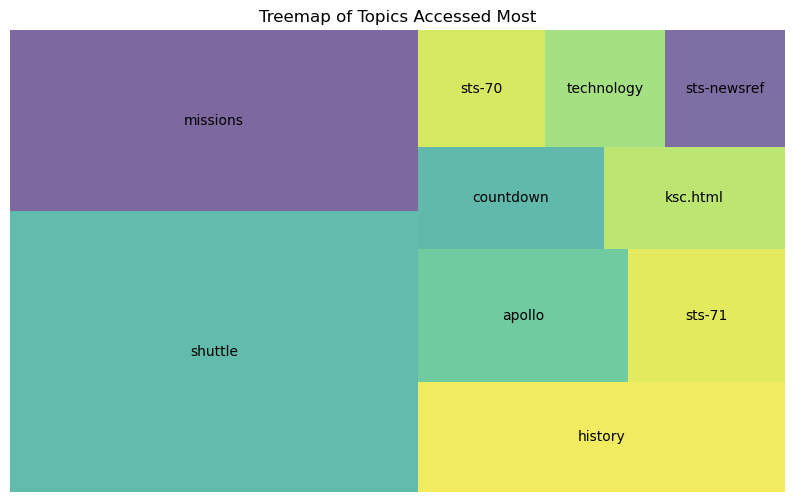

In [27]:
import matplotlib.pyplot as plt
import squarify

# Data
data = types.most_common(10)

# Extract labels and sizes
labels = [item[0] for item in data]
sizes = [item[1] for item in data]

# Plot treemap
plt.figure(figsize=(10, 6))
squarify.plot(sizes=sizes, label=labels, alpha=0.7)
plt.axis('off')
plt.title('Treemap of Topics Accessed Most')
plt.show()


In [28]:
df = final.copy()

In [29]:
def is_history(value):
    if 'hist' in value.lower():
        return 1
    else:
        return 0
def is_shuttle(value):
    if 'shutt' in value.lower():
        return 1
    else:
        return 0
def is_missions(value):
    if 'mission' in value.lower():
        return 1
    else:
        return 0
def is_ksc(value):
    if 'ksc' in value.lower():
        return 1
    else:
        return 0
def is_sts(value):
    if 'sts' in value.lower():
        return 1
    else:
        return 0

In [30]:
df['history'] = df['Current'].apply(is_history)
df['shuttle'] = df['Current'].apply(is_shuttle)
df['missions'] = df['Current'].apply(is_missions)
df['ksc'] = df['Current'].apply(is_ksc)
df['sts'] = df['Current'].apply(is_sts)

In [31]:
df.iloc[:10,:]

,host,sessionID,date (DD-MM-YYYY),time (HH:MM:SS),method,url,response,domain,Current,Next,Probability,history,shuttle,missions,ksc,sts
0,199.120.110.21,199.120.110.21_1,30-06-1995,10:30:09,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,199.120.110.21,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
1,magicall.dacom.co.kr,magicall.dacom.co.kr_1,30-06-1995,10:50:13,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,co.kr,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
2,blv-pm2-ip16.halcyon.com,blv-pm2-ip16.halcyon.com_1,30-06-1995,10:56:31,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,halcyon.com,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
3,winnie.freenet.mb.ca,winnie.freenet.mb.ca_1,30-06-1995,11:56:50,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,mb.ca,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
4,queen.torfree.net,queen.torfree.net_1,30-06-1995,12:13:30,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,torfree.net,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
5,scooter.pa-x.dec.com,scooter.pa-x.dec.com_2,30-06-1995,13:31:05,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,dec.com,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
6,dial023.vanderbilt.edu,dial023.vanderbilt.edu_1,30-06-1995,13:35:24,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,vanderbilt.edu,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
7,www-d3.proxy.aol.com,www-d3.proxy.aol.com_5,30-06-1995,14:51:58,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,aol.com,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
8,dawn14.cs.berkeley.edu,dawn14.cs.berkeley.edu_2,30-06-1995,16:41:34,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,berkeley.edu,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
9,ccfews03.center.osaka-u.ac.jp,ccfews03.center.osaka-u.ac.jp_2,30-06-1995,18:44:56,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,ac.jp,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1


In [32]:
df.head()

,host,sessionID,date (DD-MM-YYYY),time (HH:MM:SS),method,url,response,domain,Current,Next,Probability,history,shuttle,missions,ksc,sts
0,199.120.110.21,199.120.110.21_1,30-06-1995,10:30:09,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,199.120.110.21,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
1,magicall.dacom.co.kr,magicall.dacom.co.kr_1,30-06-1995,10:50:13,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,co.kr,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
2,blv-pm2-ip16.halcyon.com,blv-pm2-ip16.halcyon.com_1,30-06-1995,10:56:31,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,halcyon.com,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
3,winnie.freenet.mb.ca,winnie.freenet.mb.ca_1,30-06-1995,11:56:50,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,mb.ca,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1
4,queen.torfree.net,queen.torfree.net_1,30-06-1995,12:13:30,GET,/shuttle/missions/sts-73/mission-sts-73.html,200,torfree.net,/shuttle/missions/sts-73/mission-sts-73.html,/shuttle/missions/sts-74/mission-sts-74.html,0.31288,0,1,1,0,1


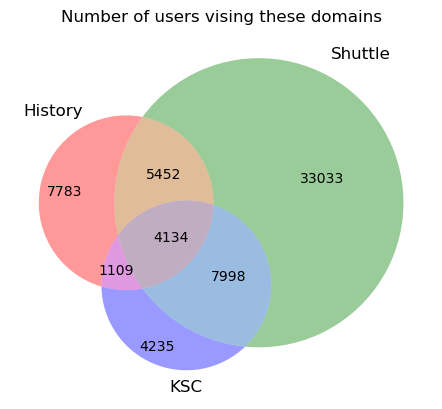

In [33]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn3


# Create sets for Venn diagram
sets = {
    'history': set(df[df['history'] == 1]['host']),
    'shuttle': set(df[df['shuttle'] == 1]['host']),
    'missions': set(df[df['missions'] == 1]['host']),
    'ksc': set(df[df['ksc'] == 1]['host']),
    'sts': set(df[df['sts'] == 1]['host'])
}

# Plot Venn diagram
venn3([sets['history'], sets['shuttle'], sets['ksc']], ('History', 'Shuttle', 'KSC'))
plt.title('Number of users vising these domains')
plt.show()


In [232]:
dataset = pd.read_csv(f1, low_memory=False)

In [233]:
dataset[dataset['url'].str.contains('mp4')].count()

host                 2
sessionID            2
date (DD-MM-YYYY)    2
time (HH:MM:SS)      2
method               2
url                  2
 response            2
dtype: int64

In [234]:
df[~df['url'].str.contains(r'\.gif$|\.html$|\.jpeg$|\.jpg$|\.mp4$', regex=True, case=False)].count()

host                 351
sessionID            351
date (DD-MM-YYYY)    351
time (HH:MM:SS)      351
method               351
url                  351
 response            351
domain               351
Current              351
Next                 314
Probability          351
history              351
shuttle              351
missions             351
ksc                  351
sts                  351
dtype: int64